In [184]:
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import LinearOperator

%matplotlib widget


In [185]:
def radial_fdm_laplacian(r_max, n, left_bc = 'neumann_simple'):
    """Generate laplacian in 2d polar coordinates, radial part.
    
    Discretize [0, r_max] with n+2 points, and apply
    neumann conditions on r=0 and Dirichlet on r=r_max, 
    resulting in an nxn matrix for the inner grid points.
    
    Args:
        r_max (float): right endpoint
        n (int): number of inner grid points
        left_bc (str, optional): 'neumann' for fancy neumann BC, 'neumann_simple' for simple Neumann, else dirichlet.
    
    Returns:
        ndarray: Laplacian as CRS matrix
        r: radial grid with endpoints
        G: transition matrix from inner to global grid
    
    """
    r = np.linspace(0, r_max, n+2)
    L = np.zeros((n,n+2))
    h = r[1]-r[0]
    
    for i in range(1,n+1):
        L[i-1,i+1] = (r[i]+h/2)/r[i]
        L[i-1,i-1] = (r[i]-h/2)/r[i]
        L[i-1,i] = -2 #-(r[i] + h/2)/r[i] - (r[i] - h/2)/r[i]
    
    G = np.zeros((n+2,n))
    G[1:-1,:] = np.eye(n)
    if left_bc == 'neumann_simple':
        G[0,0] = 1.0

    elif left_bc == 'neumann':
        G[0,0] = 1.0
        G[0,0] = 4/3
        G[0,1] = -1/3
    else:
        pass
    
    L1 = L @ G / h**2
    return L1, r, G

In [195]:
class polar_fdm_2d:
    """Class for 2d polar FDM SE solver.
    
    Attributes:
        r_max (float): right endpoint
        n_r (int): number of inner grid points
        m_max (int): maximum angular momentum
        L_neumann (ndarray): radial laplacian with Neumann BC
        L_0 (ndarray): radial laplacian with Dirichlet BC
        r0 (ndarray): radial grid with endpoints
        r_inner (ndarray): inner radial grid points
        G_neumann (ndarray): transition matrix from inner to global grid with Neumann BC
        G_0 (ndarray): transition matrix from inner to global grid with Dirichlet BC
        T_m (list of ndarray): Kinetic energy for each |m|
        V_m (list of ndarray): list of potential matrices V(r) for each m.
        V_m_max (int): number of potential matrices
    """
    
    def __init__(self, r_max, n_r, m_max):
        """Initialize the polar FDM grid.
        
        Args:
            r_max (float): right endpoint
            n_r (int): number of inner grid points
            m_max (int): maximum angular momentum
        """
        self.r_max = r_max
        self.n_r = n_r
        self.m_max = m_max

        # Set up radial laplacian for Neumann and Dirichlet BC
        self.L_neumann, self.r0, self.G_neumann = radial_fdm_laplacian(r_max, n_r, left_bc = 'neumann_simple')
        self.L_neumann = csr_matrix(self.L_neumann)
        self.L_0, _, self.G_0 = radial_fdm_laplacian(r_max, n_r, left_bc = 'dirichlet')
        self.L_0 = csr_matrix(self.L_0)
        self.r_inner = self.r0[1:-1]        
        
        # Set up Kinetic energy for each |m|
        self.T_m = []
        for m in range(m_max+1):
            if m == 0:
                self.T_m.append( -0.5*self.L_neumann  )
            else:
                self.T_m.append( -0.5*self.L_0 + np.diag(.5*m**2/self.r_inner**2) )
                
        
        # Set wavefunction shape
        self.shape = (n_r, 2*m_max + 1)
        # Set number of degrees of freedom
        self.n_dof = np.prod(self.shape)

            

    def set_potential(self, V_m):
        """ Set the scalar potential.
        
        
        Args:
            V_m (list of ndarray): list of potential matrices V(r) for each m.
        """
        self.V_m = V_m
        self.V_m_max = (len(V_m) - 1)//2
        ic(self.V_m_max)


    def apply_weight(self, psi):
        """RHS of the SE with weight function, generalized EVP"""
        
        result = np.zeros(self.shape, dtype=np.complex128)
        for m in range(-self.m_max, self.m_max+1):
            result[:,m+self.m_max] = self.r_inner * psi[:,m+self.m_max] 
            
        return result
        
    def apply_hamiltonian(self, psi, gen_evp=False):
        """Apply the Hamiltonian to a wavefunction.
        """
        
        
        assert(psi.shape == self.shape)
        result = np.zeros(self.shape, dtype=np.complex128)
        
        for m in range(-self.m_max, self.m_max+1):
            m_index = m + self.m_max
            #ic(m, m_index)
            result[:,m_index] = self.T_m[abs(m)] @ psi[:,m_index] 
            for m2 in range(-self.V_m_max, self.V_m_max+1):
                m2_index = self.V_m_max + m2
                m3 = m - m2
                if m3 >= -self.m_max and m3 <= self.m_max:
                    m3_index = m3 + self.m_max
                    #ic(m_index, m2_index, m3_index)
                    result[:,m_index] += self.V_m[m2_index] * psi[:,m3_index]
            if gen_evp:
                result[:,m_index] *= self.r_inner
        
        return result
    
    def get_dense_matrix(self):
        """Compute dense matrix representation of H."""
        def apply_hamiltonian(psi_vec):
            return self.apply_hamiltonian(psi_vec.reshape(self.shape)).flatten()

        H = LinearOperator((self.n_dof, self.n_dof), matvec=apply_hamiltonian, dtype=np.complex128)
        
        H_mat = np.zeros((self.n_dof, self.n_dof), dtype=np.complex128)
        R_mat = np.zeros((self.n_dof, self.n_dof), dtype=np.complex128)
        
        ic(self.n_dof)
        for i in range(self.n_dof):
            e = np.zeros(self.n_dof)
            e[i] = 1
            H_mat[:,i] = self.apply_hamiltonian(e.reshape(self.shape), gen_evp=True).flatten()
            R_mat[:,i] = self.apply_weight(e.reshape(self.shape)).flatten()
            
        return H_mat, R_mat

        
        
    

ic| self.V_m_max: 1
ic| self.n_dof: 2100


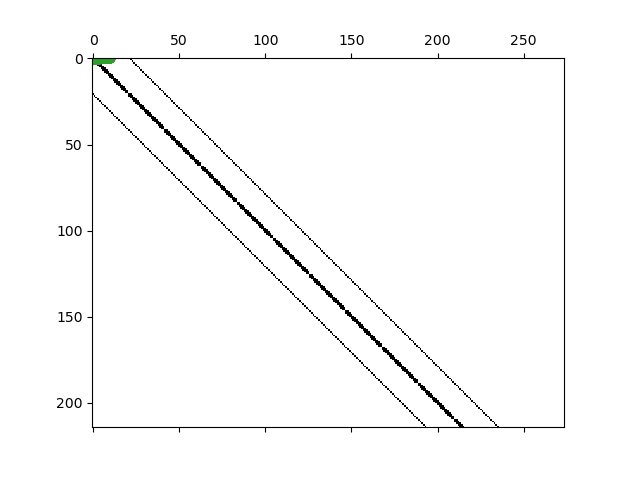

In [196]:
solver = polar_fdm_2d(r_max = 10, n_r = 100, m_max = 10)

# Set up potential V(x, y) = (x-x0)**2/2 + (y-y0)**2/2.
# This gives an harmonic oscillator with spectrum 1, 2, 2, 3, 3, 3, 4, 4, 4, 4, ...
#
# V(x, y) = (x-x0)**2/2 + (y-y0)**2/2 = r**2/2 - x*x0 - y*y0 + x0**2/2 + y0**2/2
# = r**2/2 - r*cos(theta)*x0 - r*sin(theta)*y0 + x0**2/2 + y0**2/2
# = r**2/2 - x0*r*(exp(i*theta) + exp(-i*theta))/2 - x0*r*(exp(i*tjheta)-exp(-i*theta))/2i + x0**2/2 + y0**2/2 
# = r**2/2 - r*(x0 - i*y0)/2 * exp(i*theta) - r*(x0 + i*y0)/2 * exp(-i*theta) + x0**2/2 + y0**2/2

# For all alpha, this is just a shifted harmonic oscillator
# and should produce evenly spaced energy levels with correct degeneracies 1, 2, 3. ...
x0 = 1.0
y0 = 0.25
alpha = x0 - 1j*y0
V_m = []
# m = -1
V_m.append(-alpha*0.5*solver.r_inner)
V_m.append(0.5*solver.r_inner**2 + 0.5*np.abs(alpha)**2)
V_m.append(-alpha.conjugate()*0.5*solver.r_inner)
solver.set_potential(V_m)

# Compute dense matrix version of Hamiltonian.
H_mat, R_mat = solver.get_dense_matrix()

# Plot sparsity pattern. Zoom in for details.
plt.figure
plt.spy(H_mat)
plt.show()


In [198]:
# Compute the first eigenvalues and the differences between them.
# For a HO this should give approximately, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1.
from scipy.linalg import eigh
E, U = eigh(H_mat, R_mat)
i = np.argsort(E)
E = E[i]
U = U[:,i]
ic(E[:11])


ic| E[:11]: array([0.99988295, 1.99920904, 2.0004669 , 2.99710153, 2.99819221,
                   2.99982793, 3.99508431, 3.99652469, 3.99761584, 3.99904066,
                   4.99280179])


array([0.99988295, 1.99920904, 2.0004669 , 2.99710153, 2.99819221,
       2.99982793, 3.99508431, 3.99652469, 3.99761584, 3.99904066,
       4.99280179])

In [203]:
from scipy.sparse.linalg import eigs, cg

sigma = 1.0
def apply_hamiltonian(psi_vec, sigma = 0):
    return solver.apply_hamiltonian(psi_vec.reshape(solver.shape), gen_evp=True).flatten() - sigma*psi_vec
def apply_weight(psi_vec):
    return solver.apply_weight(psi_vec.reshape(solver.shape)).flatten()

H = LinearOperator((solver.n_dof, solver.n_dof), matvec=apply_hamiltonian, dtype=np.complex128)
R = LinearOperator((solver.n_dof, solver.n_dof), matvec=apply_weight, dtype=np.complex128)


from time import time
start = time()
result = eigs(H, 10, R, which='LM', sigma=sigma, tol=1e-6, maxiter=1000)

psi_vec = np.random.rand(solver.n_dof)

# for k in range(10):
#     psi_vec = cg(H, psi_vec, tol=1e-6, maxiter=1000)[0]
#     psi_vec /= np.linalg.norm(psi_vec)
#     E = psi_vec.conjugate().T @ (H @ psi_vec)
#     ic(E)
    


ic(time() - start)


KeyboardInterrupt: 

In [118]:
np.diff(result[0])

array([1.99519287+2.96263399e-14j, 1.99036812-1.90093082e-14j,
       1.98552215+5.07231050e-15j, 1.98065473-1.82708755e-15j,
       1.97576563-2.00986185e-15j, 1.97085461+1.14619244e-15j,
       1.96592146+3.24574424e-15j, 1.96096596-9.88483542e-15j,
       1.95598789-1.85318485e-15j])

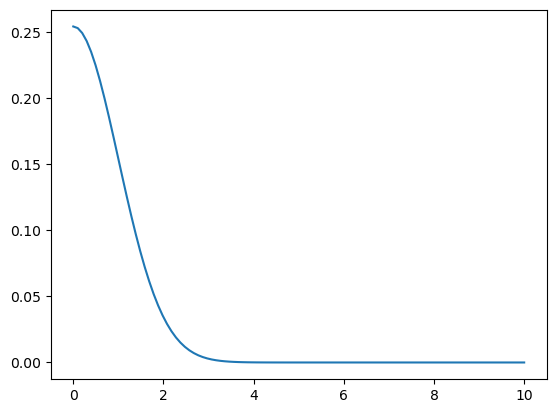

In [116]:
psi = result[1][:,0].reshape(solver.shape)
plt.figure()
plt.plot(solver.r0, solver.G_neumann @ psi[:,0].real)
plt.show()


In [111]:
H_solver = solver.T_m[0] + solver.V_m[0]
ic(H_solver.shape)


ic| H_solver.shape: (100, 100)


(100, 100)